In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-03-16-02-41-42']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [4]:
# crete a dataframe from runs and summary metrics
# async def add_max_to_summary(run):
#     try:
#         history: pd.DataFrame = run.history()
#         # get the row with the highest Self_Play/Mean_Reward
#         metric = "Self_Play/Mean_Reward"
#         best_row = history.loc[history[metric].idxmax()]
#         run.summary[f'max_{metric}'] = best_row[metric]
#         run.summary[f'max_{metric}_step'] = best_row['_step']
#         run.summary.update()
#     except:
#         pass



# async def get_history(run):
#     return await run.history()

# tasks = []
# for run in runs:
#     if run.state != "finished":
#         continue
#     tasks.append(add_max_to_summary(run))

# await asyncio.gather(*tasks)


data = []
for run in tqdm(runs):
    history: pd.DataFrame = run.history()
    for i, row in history.iterrows():
        # add a row to the data with run.config and the history row merged
        data.append({**run.config, **row})

df = pd.DataFrame(data)

df


100%|██████████| 48/48 [00:30<00:00,  1.59it/s]


,ncols,layers,puct_c,workers,lr_gamma,dir_alpha,env_params,eval_param,hidden_dim,iterations,...,Training/Value_loss,Self_Play/Min_Return,Training/Learning_Rate,grad_steps,Self_Play/Total_Timesteps,_runtime,Training/Regularization_loss,Self_Play/Entropies,Training/Value_and_Policy_loss,_timestamp
0,8.0,7,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,32,20,...,2.916788e-10,0,0.001,0,900,802.365630,189.046936,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.013324,1.710582e+09
1,8.0,7,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,32,20,...,2.748380e-10,0,0.001,3,900,1501.898679,189.144714,"{'bins': [0.6344602108001709, 0.63494139909744...",0.013206,1.710583e+09
2,8.0,7,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,32,20,...,5.322721e-10,0,0.001,6,900,2115.130722,189.214645,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0...",0.022251,1.710583e+09
3,8.0,7,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,32,20,...,7.616973e-10,0,0.001,9,900,2639.950243,189.302887,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...",0.020386,1.710584e+09
4,8.0,7,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,32,20,...,7.478472e-10,0,0.001,12,900,7738.629110,189.421005,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0...",0.022725,1.710589e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,NaN,7,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",10,32,30,...,3.104321e+01,9,0.001,75,81,76.436805,200.828064,"{'packedBins': {'min': 0.029349610209465027, '...",21.960201,1.710553e+09
1076,NaN,7,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",10,32,30,...,4.007186e+01,10,0.001,78,68,78.972289,201.753967,"{'packedBins': {'min': 0.06082063913345337, 's...",28.282995,1.710553e+09
1077,NaN,7,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",10,32,30,...,5.417307e+01,10,0.001,81,104,82.477181,202.001175,"{'packedBins': {'count': 64, 'min': 0.02841411...",38.142811,1.710553e+09
1078,NaN,7,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",10,32,30,...,5.412138e+01,10,0.001,84,65,85.448154,201.524582,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0...",38.110099,1.710553e+09


In [5]:
df.columns

Index(['ncols', 'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha',
       'env_params', 'eval_param', 'hidden_dim', 'iterations', 'model_type',
       'norm_layer', 'dir_epsilon', 'activation_fn', 'learning_rate',
       'discount_factor', 'env_description', 'planning_budget',
       'training_epochs', 'use_visit_count', 'n_steps_learning',
       'selection_policy', 'tree_temperature', 'value_loss_weight',
       'max_episode_length', 'policy_loss_weight', 'sample_batch_ratio',
       'observation_embedding', 'regularization_weight',
       'root_selection_policy', 'episodes_per_iteration',
       'tree_evaluation_policy', 'replay_buffer_multiplier',
       'Self_Play/Returns', 'Training/Value_Simularities', '_step',
       'Self_Play/EMA_Return', 'Self_Play/Max_Return',
       'Self_Play/Min_Timesteps', 'Training/Replay_Buffer_Size',
       'Training/Policy_loss', 'Self_Play/Mean_Discounted_Returns',
       'Self_Play/Cumulative_Return', 'Self_Play/Mean_Return',
       'Self_Pla

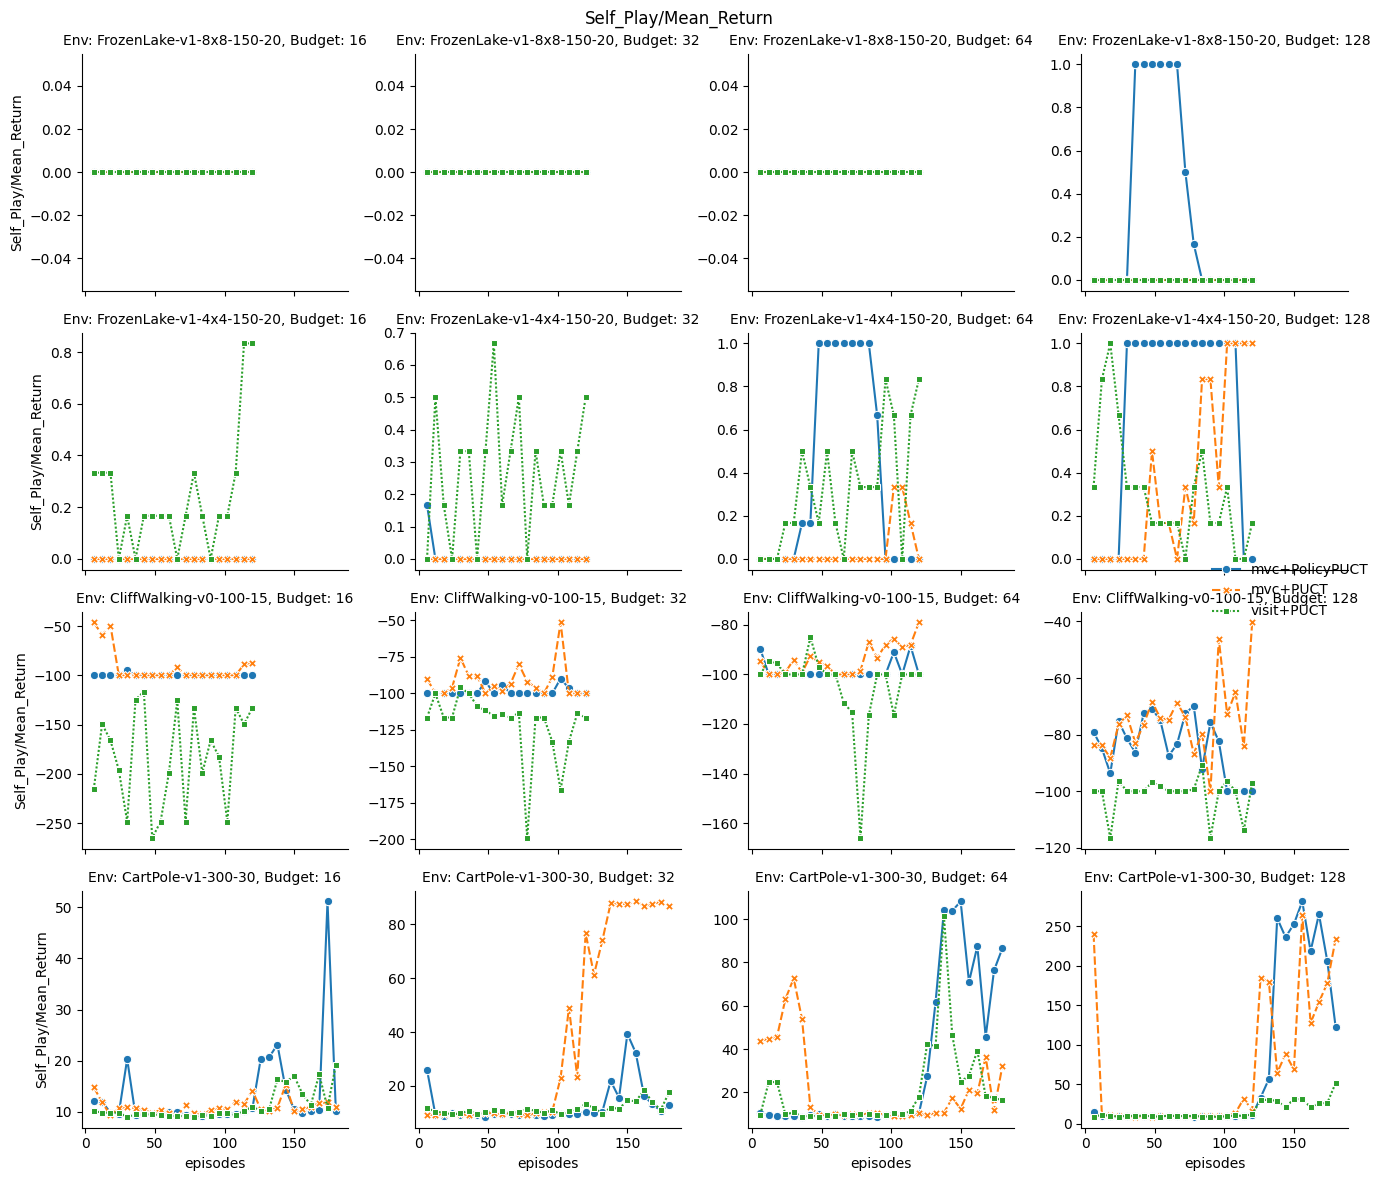

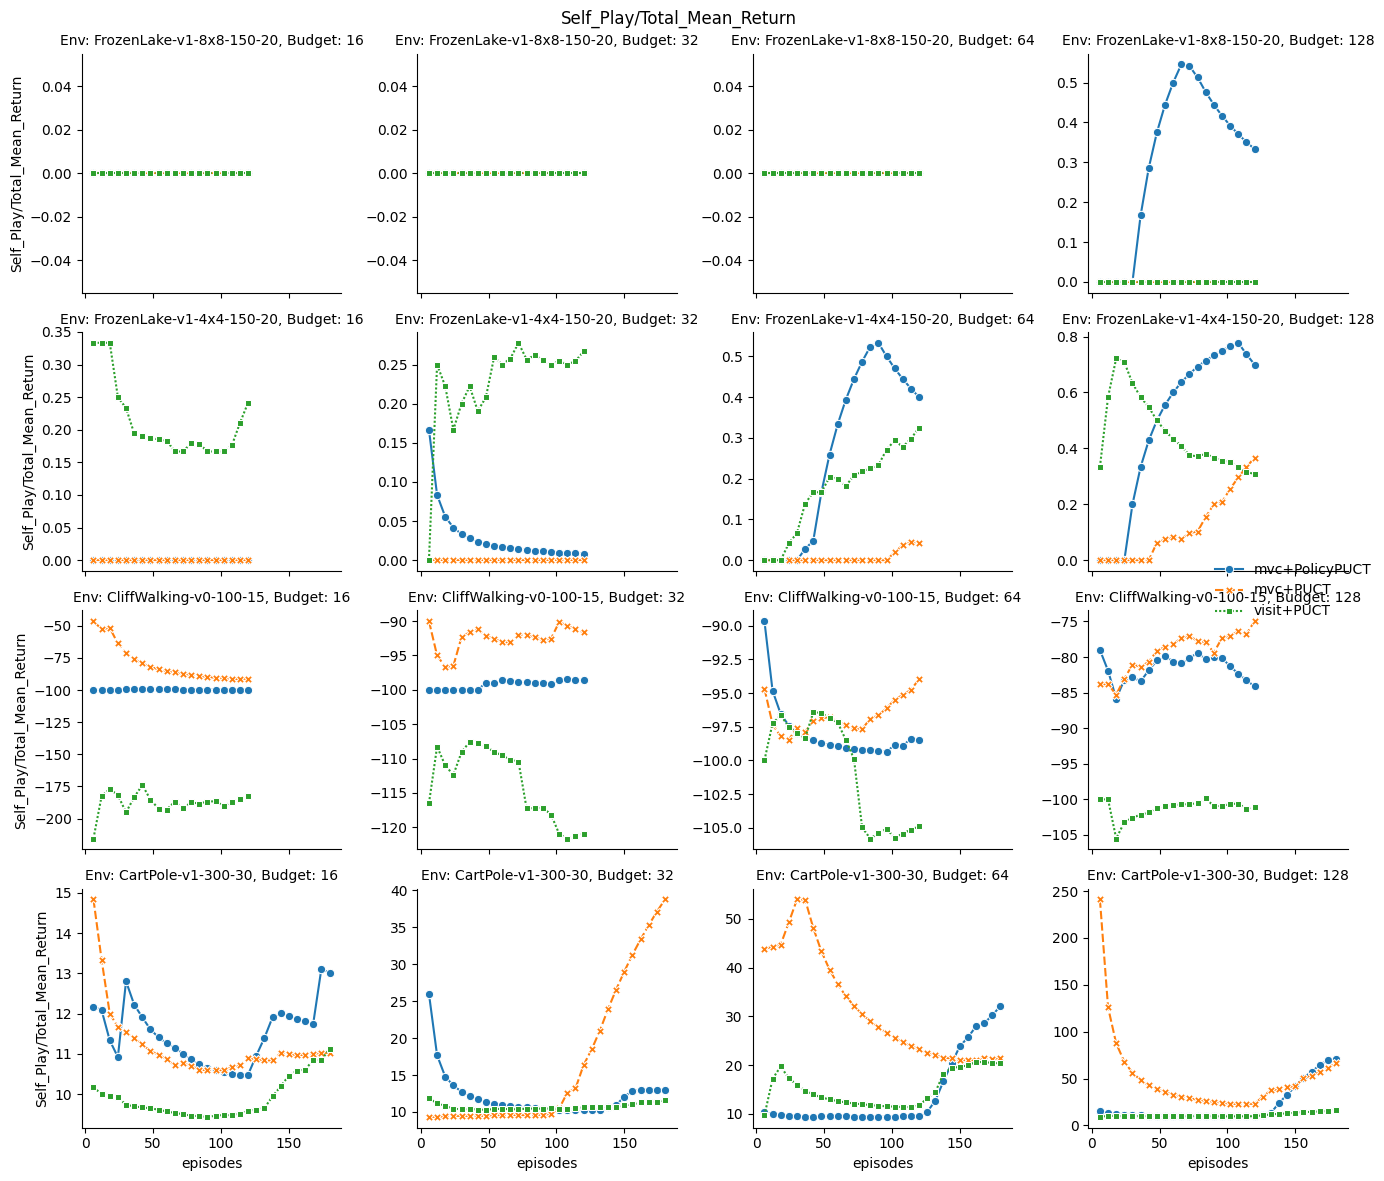

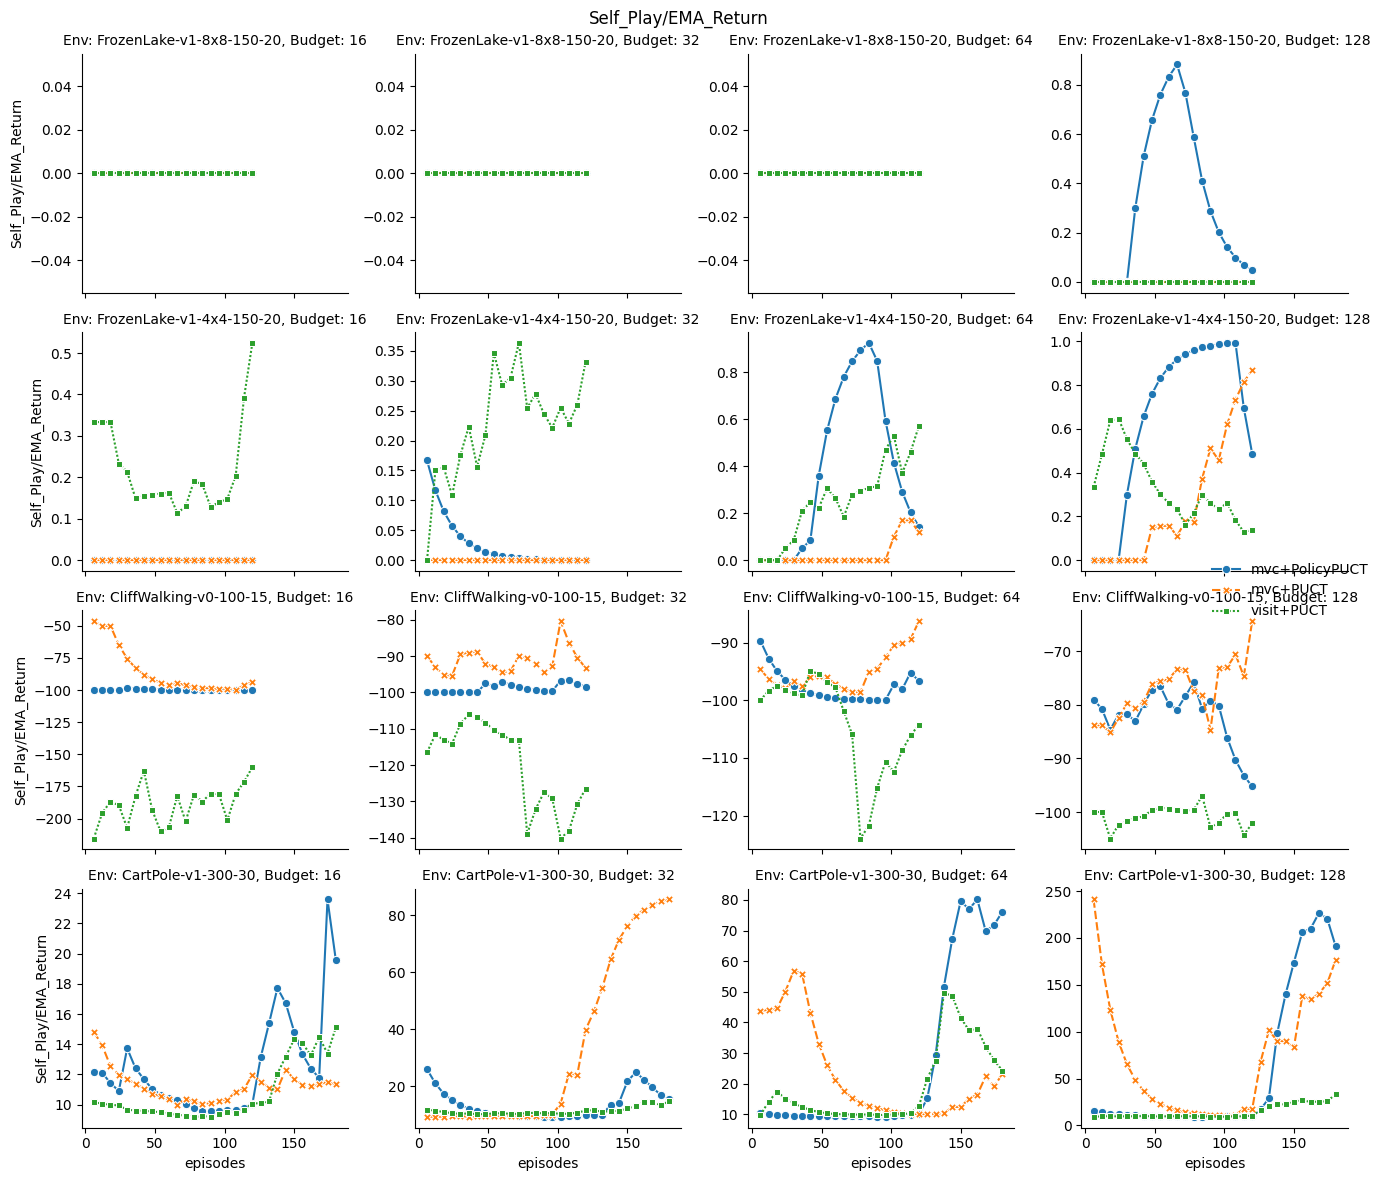

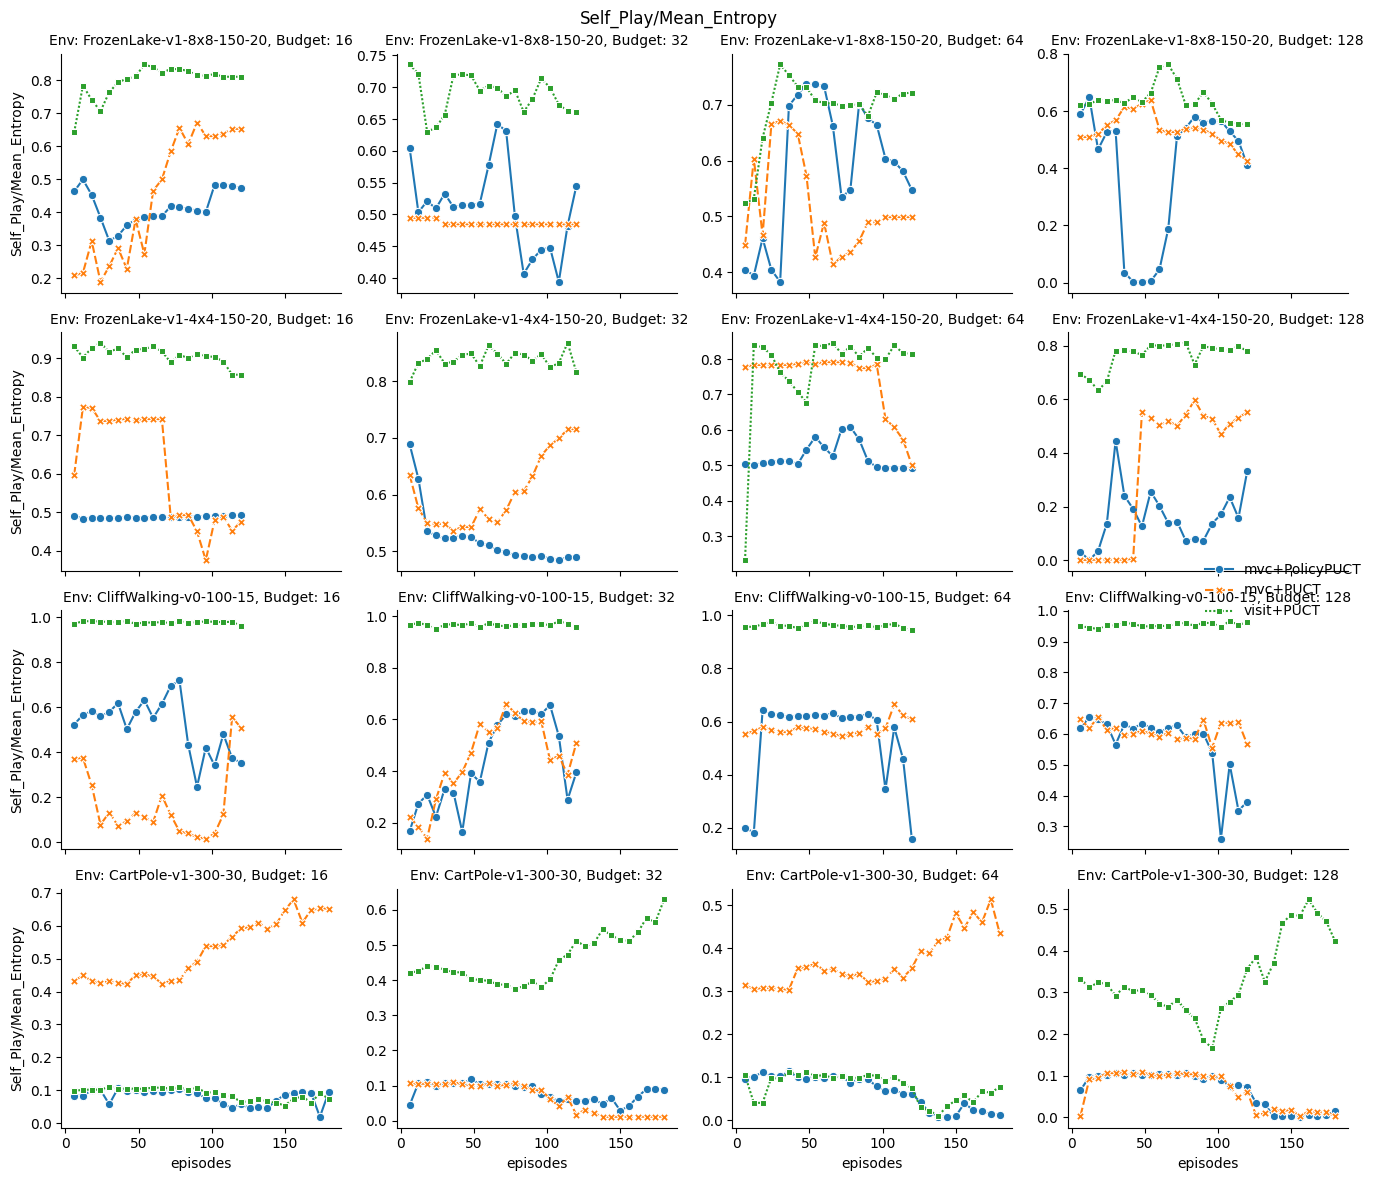

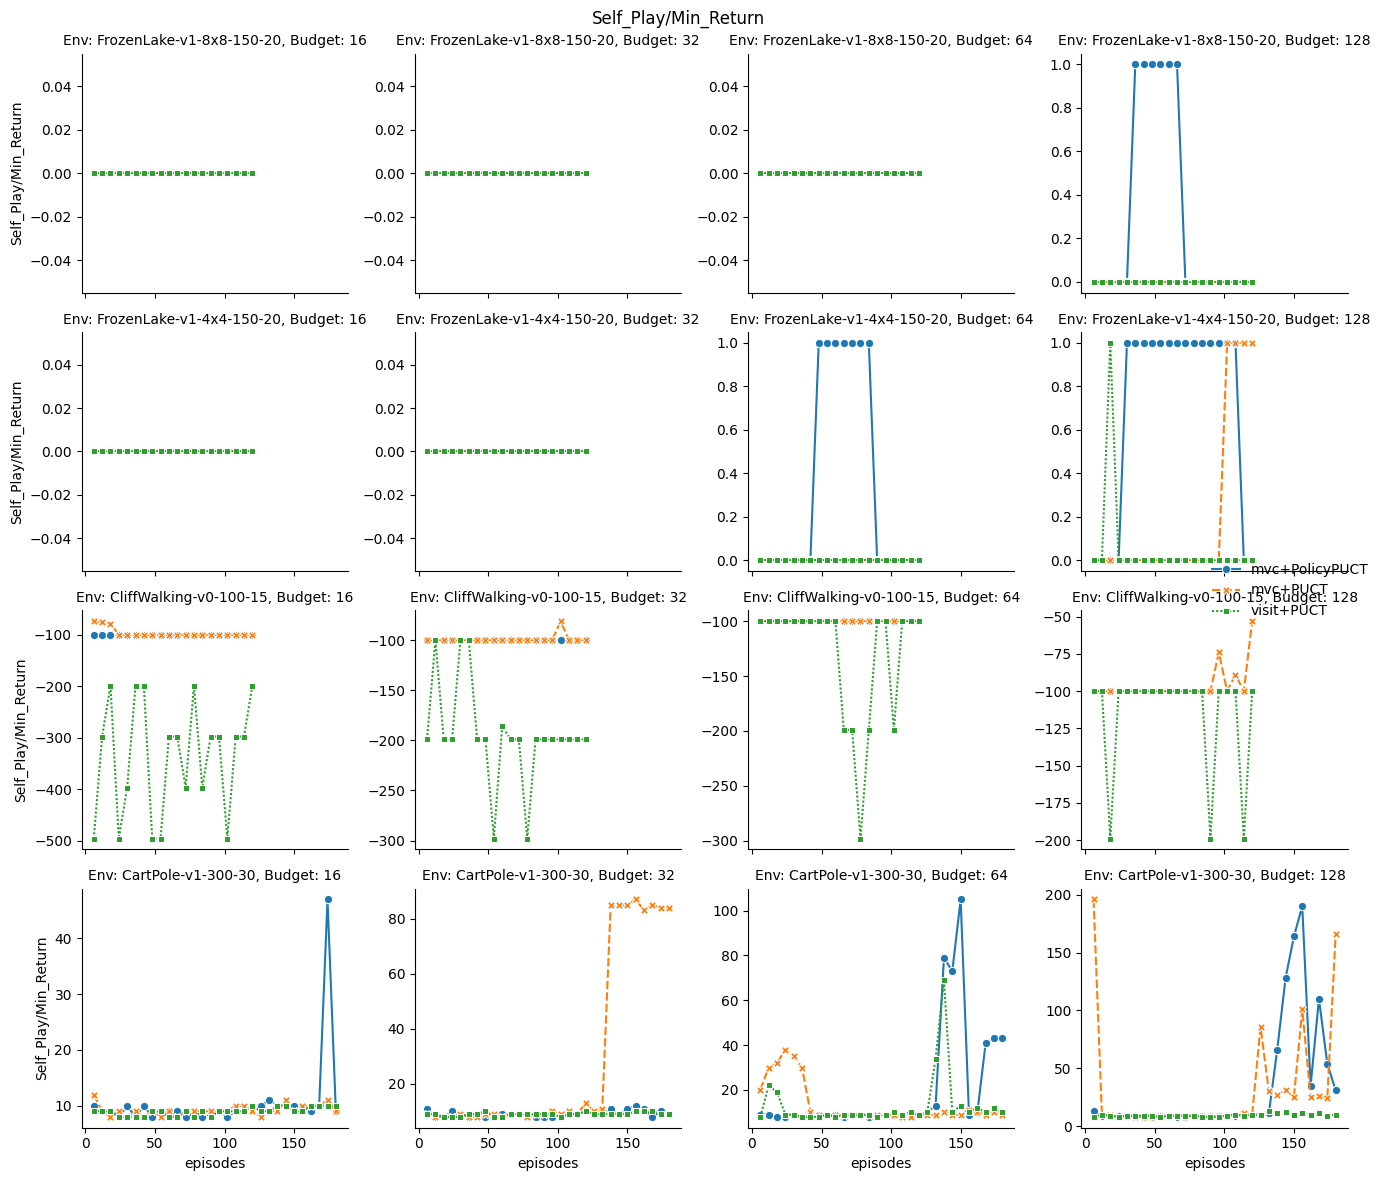

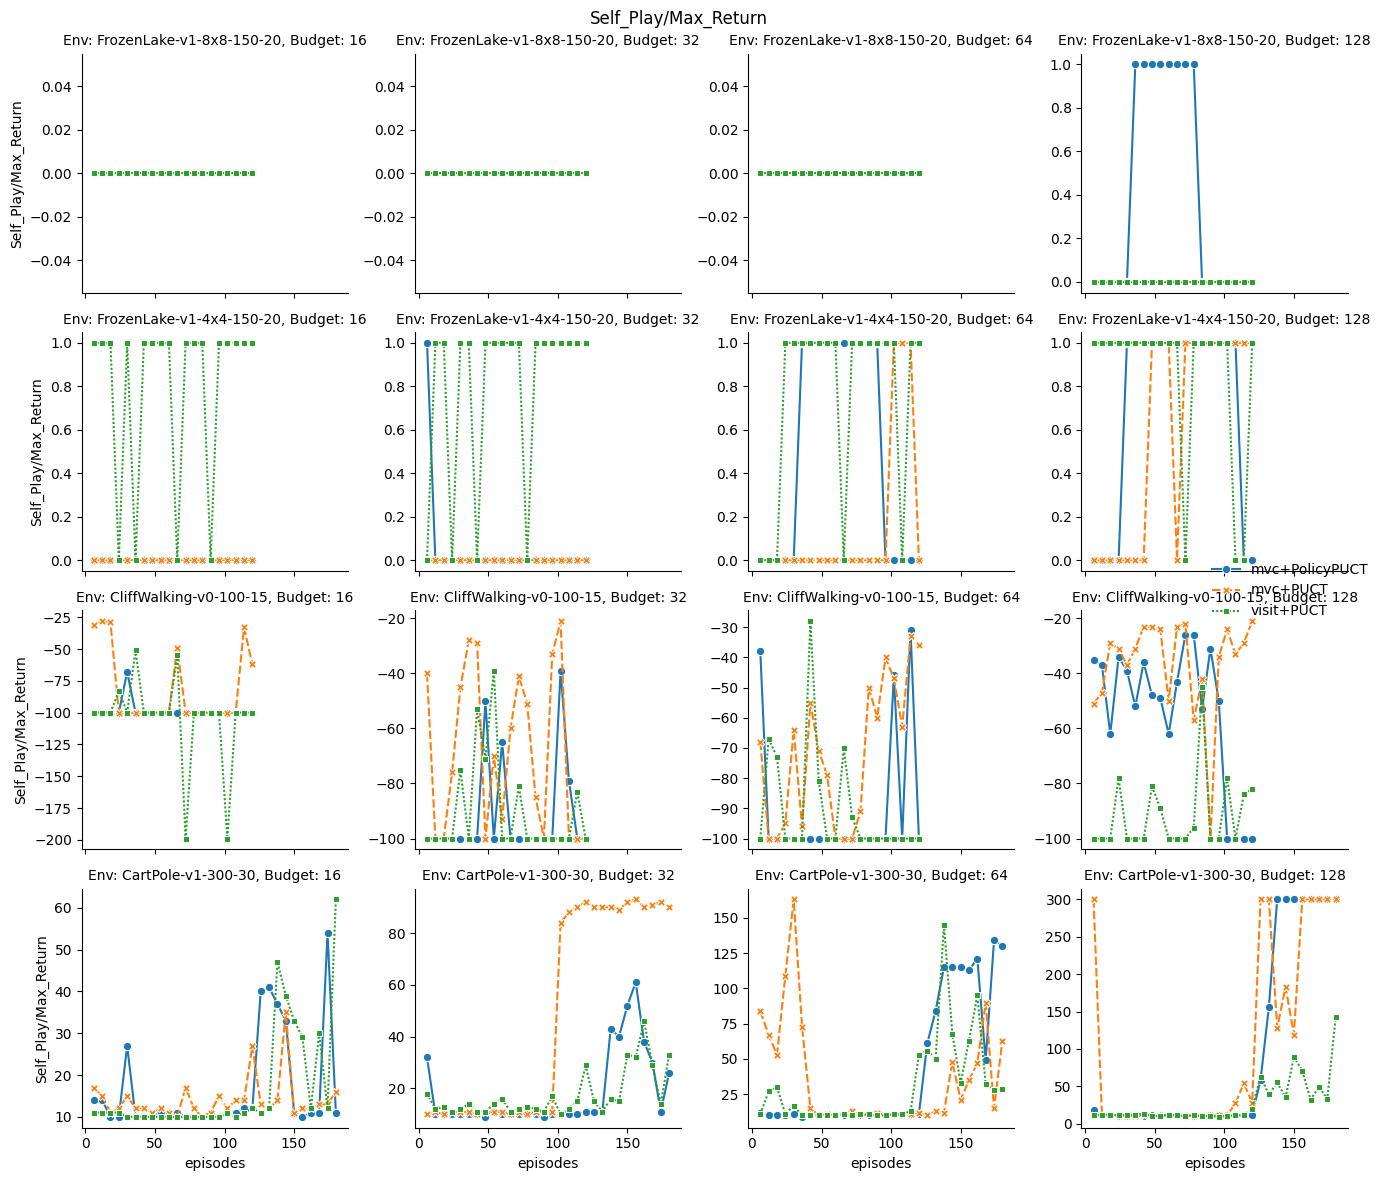

In [23]:


save_folder = 'outfiles'



df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Return', "Self_Play/Total_Mean_Return", "Self_Play/EMA_Return", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Return',
           'Self_Play/Max_Return',]
x_metric = "episodes"

estimator = "mean"

for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(data=df, row="env_description", col="planning_budget", sharex=True, sharey=False)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed


    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()
    g.set_titles("Env: {row_name}, Budget: {col_name}")


    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)
    plt.suptitle(metric)
    plt.tight_layout()
    plt.show()